In [32]:
import wfdb

In [36]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
import sklearn
import itertools
from tensorflow_addons.optimizers import CyclicalLearningRate
import matplotlib as mpl
mpl.style.use('seaborn')

In [37]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from tensorflow.keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers


%matplotlib inline

In [35]:
data_path = 'mit-bih-arrhythmia-database-1.0.0/'

In [36]:
pts = ['100','101','102','103','104','105','106','107',
       '108','109','111','112','113','114','115','116',
       '117','118','119','121','122','123','124','200',
       '201','202','203','205','207','208','209','210',
       '212','213','214','215','217','219','220','221',
       '222','223','228','230','231','232','233','234']

In [37]:
df = pd.DataFrame()

for pt in pts:
    file = data_path + pt
    annotation = wfdb.rdann(file, 'atr')
    sym = annotation.symbol
    
    values, counts = np.unique(sym, return_counts=True)
    df_sub = pd.DataFrame({'sym':values, 'val':counts, 'pt':[pt]*len(counts)})
    df = pd.concat([df, df_sub],axis = 0)

In [38]:
df.groupby('sym').val.sum().sort_values(ascending = False)

sym
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: val, dtype: int64

In [39]:
# list of nonbeat and abnormal
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

In [40]:
# break into normal, abnormal or nonbeat
df['cat'] = -1
df.loc[df.sym == 'N','cat'] = 0
df.loc[df.sym.isin(abnormal), 'cat'] = 1

In [41]:
df.groupby('cat').val.sum()

cat
-1     3186
 0    75052
 1    34409
Name: val, dtype: int64

In [42]:
#loading a single patient's signals and annotations
def load_ecg(file):
    # load the ecg
    # example file: 'mit-bih-arrhythmia-database-1.0.0/101'
    
    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')
    
    # extract the signal
    p_signal = record.p_signal
    
    # verify frequency is 360
    assert record.fs == 360, 'sample freq is not 360'
    
    # extract symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    
    return p_signal, atr_sym, atr_sample 

In [43]:
file = data_path + pts[0]

In [44]:
p_signal, atr_sym, atr_sample = load_ecg(file)

In [45]:
values, counts = np.unique(sym, return_counts=True)
for v,c in zip(values, counts):
    print(v,c)

+ 3

J 50

N 2700

V 3

~ 8


In [46]:
# get abnormal beat index
ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal][:10]
ab_index

[2044, 66792, 74986, 99579, 128085, 170719, 279576, 305709, 307745, 312825]

In [47]:
x = np.arange(len(p_signal))

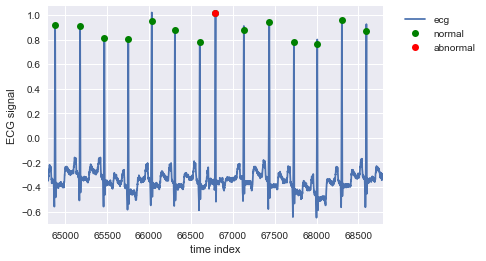

In [48]:
left = ab_index[1]-2000
right = ab_index[1]+2000

plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.show()

In [3]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

In [4]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

In [5]:
path = 'mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes


In [6]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [10]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    elif(file_extension == '.txt'):
        annotations.append(path + filename + file_extension)

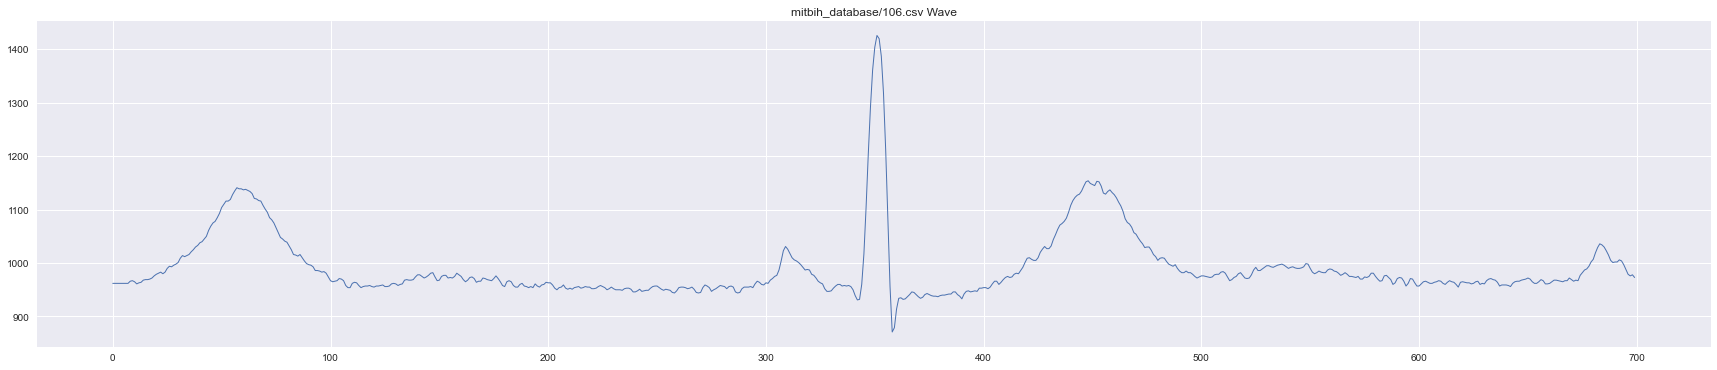

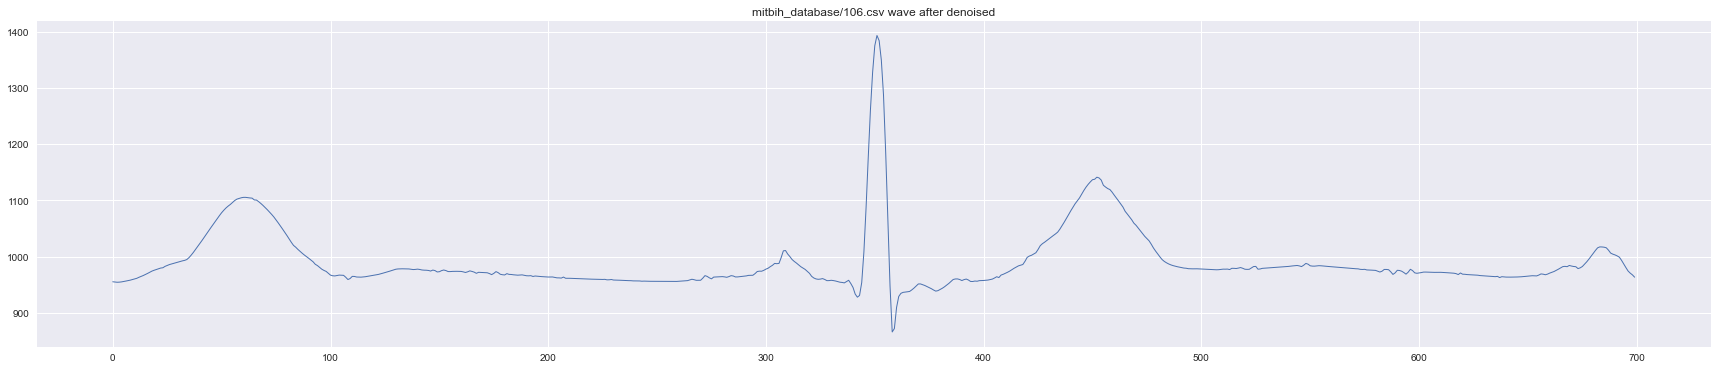

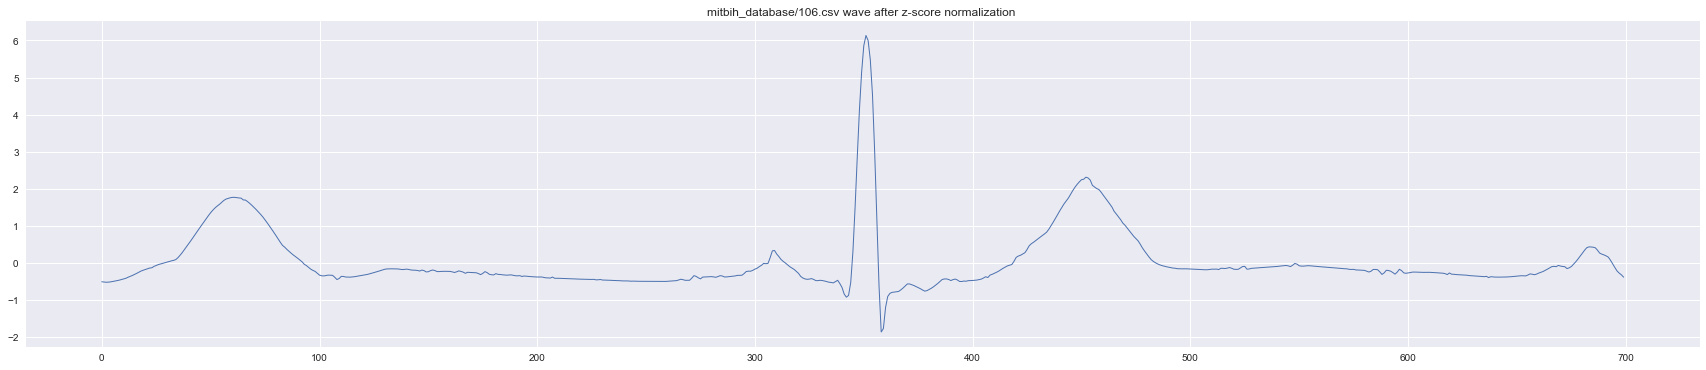

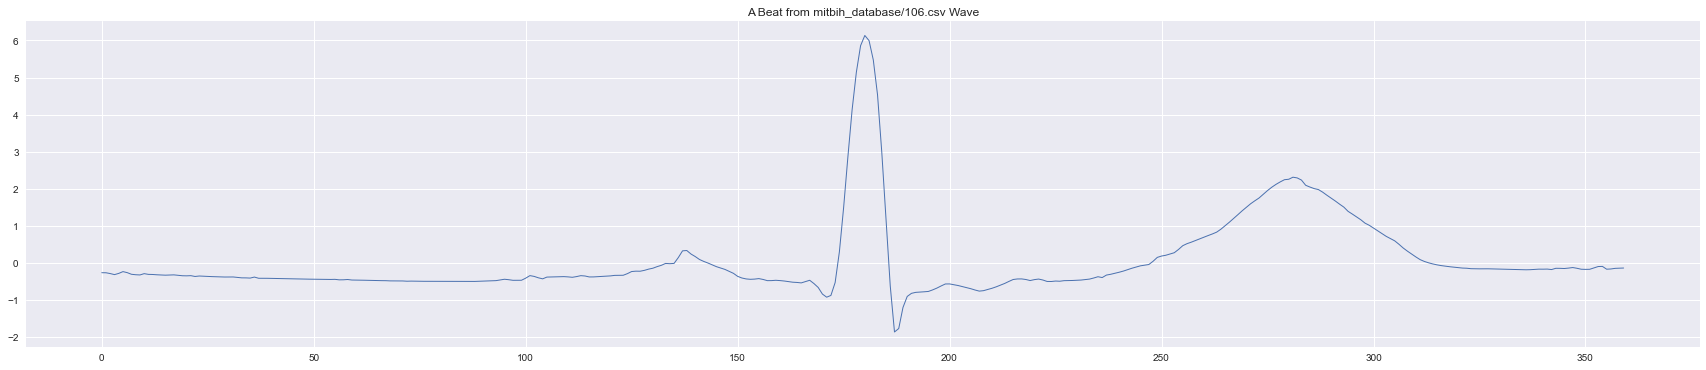

(100012, 360) (100012,)


In [11]:
# Records

X = list()
y = list()

for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                #print(row[1])
                signals.insert(row_index, int(float(row[1])))
            row_index += 1
            
    # Plot an example to the signals
    if r == 6:
        # Plot each patient's signal
        plt.title(records[6] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
    signals = denoise(signals)
    # Plot an example to the signals
    if r == 6:
        # Plot each patient's signal
        plt.title(records[6] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r == 6:
        # Plot each patient's signal
        plt.title(records[6] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ') #The split() method splits a string into a list.
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
           # if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
                #    pass
            #else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r == 6 and not example_beat_printed: 
                        plt.title("A Beat from " + records[6] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

In [12]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100012, 361)


In [13]:
len(y)

100012

360

0.0    75011

1.0     8071

2.0     7255

4.0     7129

3.0     2546

Name: count, dtype: int64


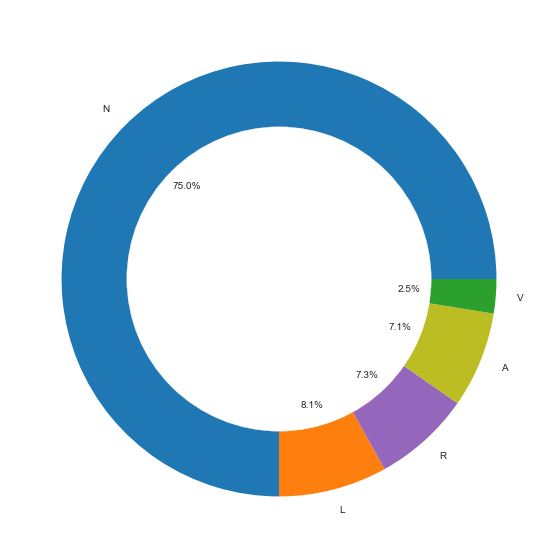

In [14]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(30,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [15]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

360

0.0    5000

1.0    5000

2.0    5000

3.0    5000

4.0    5000

Name: count, dtype: int64


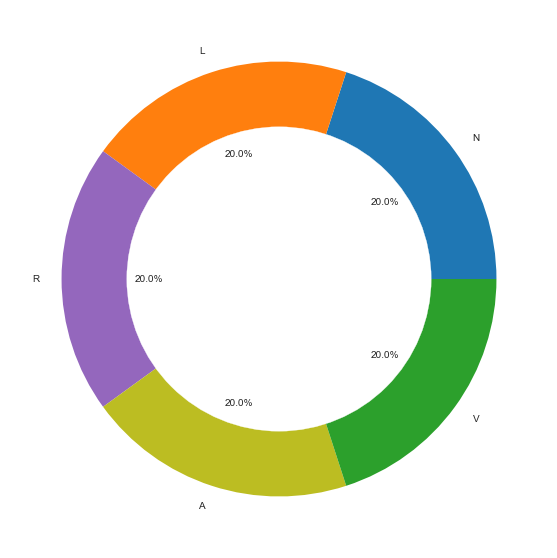

In [16]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

In [ ]:
# train shape = 20000 * 361
# 361 rows and 20000 columns

target_train=train[train.shape[1]-1]

#target_train size is (20000,)


target_test=test[test.shape[1]-1]

#target_test size is 50000


train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

In [ ]:
train_y

In [ ]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

In [ ]:
mitbih_test = test
mitbih_train = train

In [ ]:
mitbih_train.shape

In [ ]:

mitbih_labels = {'N': 0, 'L': 1, 'R': 2, 'A': 3, 'V': 4}
mitbih_reverse_labels = {v:k for k,v in mitbih_labels.items()}
mitbih_train_labels = mitbih_train.iloc[:,-1].replace(mitbih_reverse_labels)
     

In [ ]:
plt.hist(mitbih_train_labels)
plt.title("Distribution of labels in MIT-BIH Arhythmia dataset")

In [ ]:
plt.plot(mitbih_train.iloc[0,:-2])
plt.xlabel('Time')
plt.ylabel('Normalized activation')
plt.title("MIT-BIH Arrhythmia Dataset example signal")

In [ ]:
print("There are {} nan values in the train data.".format(mitbih_train.isna().sum().sum()))
print("There are {} nan values in the test data.".format(mitbih_test.isna().sum().sum()))

In [ ]:
print("The minimum and maximum values are {}, {}".format(np.min(mitbih_train.iloc[:,:-2].values), np.max(mitbih_train.iloc[:,:-2].values)))

### Helper Functions

In [ ]:

from tensorflow.keras.callbacks import Callback

class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

In [ ]:
def pretty_plot(history, field, fn):
    def plot(data, val_data, best_index, best_value, title):
        plt.plot(range(1, len(data)+1), data, label='train')
        plt.plot(range(1, len(data)+1), val_data, label='validation')
        if not best_index is None:
            plt.axvline(x=best_index+1, linestyle=':', c="#777777")
        if not best_value is None:
            plt.axhline(y=best_value, linestyle=':', c="#777777")
        plt.xlabel('Epoch')
        plt.ylabel(field)
        plt.xticks(range(0, len(data), 20))
        plt.title(title)
        plt.legend()
        plt.show()
        
    data = history.history[field]
    val_data = history.history['val_' + field]
    tail = int(0.15 * len(data))
    best_index = fn(val_data)
    best_value = val_data[best_index]
    plot(data, val_data, best_index, best_value, "{} over epochs (best {:06.4f})".format(field, best_value))
    plot(data[-tail:], val_data[-tail:], None, best_value, "{} over last {} epochs".format(field, tail))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def get_base_model(categories=2):
    return keras.Sequential([
    keras.layers.Dense(15, activation='relu', input_shape=[187], kernel_regularizer=regularizers.l2(0.0001)),
    keras.layers.Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    keras.layers.Dense(5, activation='relu'),
    (keras.layers.Dense(1, activation='sigmoid') if categories == 2 else keras.layers.Dense(5, activation='softmax'))                   
  ])

In [ ]:
tf.keras.utils.plot_model(
    get_base_model(),
    to_file="model.png")

In [ ]:
X_mitbih_train, X_mitbih_val, y_mitbih_train, y_mitbih_val = train_test_split(mitbih_train.iloc[:,:-1].values, mitbih_train.iloc[:,-1].values, test_size=0.1, random_state=42)
X_mitbih_test = mitbih_test.iloc[:,:-1].values
y_mitbih_test = mitbih_test.iloc[:,-1].values

In [ ]:
# The 1D convolutions expect an extra dimension in the input data 
X_mitbihl_train = np.expand_dims(X_mitbih_train, -1)
y_mitbihl_train = np.expand_dims(y_mitbih_train, -1)
X_mitbihl_val = np.expand_dims(X_mitbih_val, -1)
y_mitbihl_val = np.expand_dims(y_mitbih_val, -1)
X_mitbihl_test = np.expand_dims(X_mitbih_test, -1)
y_mitbihl_test = np.expand_dims(y_mitbih_test, -1)

In [ ]:
import tensorflow.keras.layers as keras
from tensorflow.keras import layers
from tensorflow import keras

In [ ]:
RNN_MODEL_DIR = './Models/RNN'
RNN_OUTPUT_UNITS = [64, 128]

def rnn_model(categories=2):
    
    inputs = keras.layers.Input([360,1])
    model=Sequential()
    model.add(Dense(32,activation='relu',input_shape=(360,1)))
    model.add(LSTM(32,return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(output_size,activation='softmax'))
    adam_lr=0.005
    model.compile(optimizer = adam(lr=adam_lr) , loss='categorical_crossentropy', metrics=['accuracy'])
    return model
    
    '''current_layer = keras.layers.Masking(mask_value=0., input_shape=(360, 1), name='Masked')(inputs)
    
    current_layer = keras.layers.Bidirectional(layers.LSTM(64, return_sequences=True))(current_layer)
    current_layer = keras.layers.Bidirectional(layers.LSTM(64))(current_layer)'''
    
    '''for i, size in enumerate(RNN_OUTPUT_UNITS):
        notLast = i + 1 < len(RNN_OUTPUT_UNITS)
        layer = keras.layers.GRU(size, return_sequences=notLast, dropout=0.2, name = 'GRU' + str(i+1))
        current_layer = keras.layers.Bidirectional(layer, name = 'BiRNN' + str(i+1))(current_layer)'''

    #current_layer = keras.layers.Dense(64, name='Dense1', activation='relu')(current_layer)
    #current_layer = keras.layers.Dense(16, name='Dense2', activation='relu')(current_layer)
    #logits = keras.Dense(5, name='Output', activation='relu')(current_layer)
    '''output = keras.layers.Dense(1, activation='sigmoid')(out) if categories == 2 else keras.layers.Dense(5, activation='relu')(current_layer)

    model = keras.Model(inputs=inputs, outputs=output)

    return model
    #print('Parameter count:', parameter_count())
    #return logits'''

In [123]:
m_rnn_model.summary()

Model: "model_5"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


input_17 (InputLayer)        [(None, 360, 1)]          0         

_________________________________________________________________

Masked (Masking)             (None, 360, 1)            0         

_________________________________________________________________

BiRNN1 (Bidirectional)       (None, 360, 128)          25728     

_________________________________________________________________

BiRNN2 (Bidirectional)       (None, 256)               198144    

_________________________________________________________________

Dense1 (Dense)               (None, 64)                16448     

_________________________________________________________________

Dense2 (Dense)               (None, 16)                1040      

_________________________________________________________________

dense_16 (Dense)             (None, 5)     

In [124]:
N = mitbih_train.shape[0]
batch_size = 128
iterations = N/batch_size
step_size= 2 * iterations

lr_schedule = CyclicalLearningRate(1e-5, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
m_rnn_model = rnn_model(5)

NameError: name 'LSTM' is not defined

In [111]:


save_rnn_weights = ModelCheckpoint(filepath="weights_rnn.hdf5", verbose=0, save_best_only=True)

m_rnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_rnn = m_rnn_model.fit(X_mitbihl_train, y_mitbihl_train, validation_data=(X_mitbihl_val, y_mitbihl_val), 
                             shuffle=True, batch_size=128, epochs=30, callbacks=[save_rnn_weights])

Epoch 1/30


 43/141 [========>.....................] - ETA: 2:13:07 - loss: 2.0624 - accuracy: 0.1973

KeyboardInterrupt: 

In [31]:
def get_alexnet_model(categories=2):

    inputs = keras.layers.Input([360,1])
    kernels = 32
    stride = 5
    X = keras.layers.Conv1D(kernels, stride)(inputs)
    
    
    # Convolutional block 1
    out = keras.layers.Conv1D(kernels, strides = 4, padding='same',kernel_size = 3)(X) #conv1
    out = keras.layers.ReLU()(out)
    out = keras.layers.MaxPool1D(5, 2)(out) #max pooling 1
     
    # Convolutional block 2
    out = keras.layers.Conv1D(kernels, strides = 1, padding = 'same', kernel_size = 3)(out)
    out = keras.layers.ReLU()(out)
    out = keras.layers.MaxPool1D(5, 2)(out) #max pooling 2
    
    # Convolutional block 3
    out = keras.layers.Conv1D(kernels, strides = 1, padding='same', kernel_size = 3)(out)
    out = keras.layers.ReLU()(out)
    out = keras.layers.Conv1D(kernels, strides = 1, padding='same', kernel_size = 3)(out)
    out = keras.layers.ReLU()(out)
    out = keras.layers.Conv1D(kernels, strides = 1, padding='same', kernel_size = 3)(out)
    out = keras.layers.ReLU()(out)    
    out = keras.layers.MaxPool1D(5, 2)(out) #max pooling 3
    
    
    out = keras.layers.Flatten()(out)
    out = keras.layers.Dropout(0.5)(out) #dropout 1
                           
    out = keras.layers.Dense(4096, activation='relu')(out)  #fully connected 1
    out = keras.layers.Dropout(0.5)(out) #dropout 2 
    
    out = keras.layers.Dense(4096, activation='relu')(out) #fully connected 2
                           
    out = keras.layers.Dense(1000, activation='softmax')(out) #fully connected 3
                           
#     out = keras.layers.Dense(32, activation='relu')(out)
#     out = keras.layers.Dense(32, activation='relu')(out)
    output = (keras.layers.Dense(1, activation='sigmoid')(out) if categories == 2 else keras.layers.Dense(5, activation='softmax')(out))

    model = keras.Model(inputs=inputs, outputs=output)

    return model


In [67]:
N = mitbih_train.shape[0]
batch_size = 128
iterations = N/batch_size
step_size= 2 * iterations

lr_schedule = CyclicalLearningRate(1e-5, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
m_alexnet_model = get_alexnet_model(5)

save_alexnet_weights = ModelCheckpoint(filepath="weights_alexnet.hdf5", verbose=0, save_best_only=True)

m_alexnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_alexnet = m_alexnet_model.fit(X_mitbihl_train, y_mitbihl_train, validation_data=(X_mitbihl_val, y_mitbihl_val), 
                             shuffle=True, batch_size=128, epochs=30, callbacks=[save_alexnet_weights])

Epoch 1/30

141/141 [==============================] - 78s 529ms/step - loss: 1.5824 - accuracy: 0.2888 - val_loss: 1.5251 - val_accuracy: 0.3970

Epoch 2/30

141/141 [==============================] - 114s 808ms/step - loss: 1.4865 - accuracy: 0.3744 - val_loss: 1.4336 - val_accuracy: 0.3995

Epoch 3/30

141/141 [==============================] - 74s 524ms/step - loss: 1.4170 - accuracy: 0.3710 - val_loss: 1.3670 - val_accuracy: 0.4075

Epoch 4/30

141/141 [==============================] - 55s 393ms/step - loss: 1.3536 - accuracy: 0.3869 - val_loss: 1.3331 - val_accuracy: 0.4100

Epoch 5/30

141/141 [==============================] - 54s 382ms/step - loss: 1.3338 - accuracy: 0.3919 - val_loss: 1.3247 - val_accuracy: 0.4100

Epoch 6/30

141/141 [==============================] - 56s 394ms/step - loss: 1.3175 - accuracy: 0.3887 - val_loss: 1.2936 - val_accuracy: 0.4080

Epoch 7/30

141/141 [==============================] - 59s 416ms/step - loss: 1.3067 - accuracy: 0.3742 - val_loss: 1

## GoogleNet

In [80]:
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPool1D, AveragePooling1D, Flatten, GlobalAveragePooling1D, Dense, Dropout
from keras.layers.merge import concatenate

In [84]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv1D(filters=f1, kernel_size = 1, padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv1D(filters = f2_conv1, kernel_size = 1, padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv1D(filters = f2_conv3, kernel_size = 3, padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv1D(filters = f3_conv1, kernel_size = 1, padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv1D(filters = f3_conv5, kernel_size = 5, padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPool1D(3, strides= 1, padding = 'same')(input_layer)
  path4 = Conv1D(filters = f4, kernel_size = 1, padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

In [87]:
def GoogLeNet(categories=2):
  # input layer 
    input_layer = keras.layers.Input([360,1])
    #input_layer = Input(shape = (224, 224, 3))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
    X = Conv1D(filters = 64, kernel_size = 7, strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPool1D(pool_size = 3, strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
    X = Conv1D(filters = 64, kernel_size = 1, strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
    X = Conv1D(filters = 192, kernel_size = 3, padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPool1D(pool_size= 3, strides = 2)(X)

  # 1st Inception block
    X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

      # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPool1D(pool_size= 3, strides = 2)(X)

      # 3rd Inception block
    X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

      # Extra network 1:
    X1 = AveragePooling1D(pool_size = 5, strides = 3)(X)
    X1 = Conv1D(filters = 128, kernel_size = 1, padding = 'same', activation = 'relu')(X1)
    X1 = Flatten()(X1)
    X1 = Dense(1024, activation = 'relu')(X1)
    X1 = Dropout(0.7)(X1)
    X1 = Dense(5, activation = 'softmax')(X1)

  
  # 4th Inception block
    X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
    X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
    X2 = AveragePooling1D(pool_size = 5, strides = 3)(X)
    X2 = Conv1D(filters = 128, kernel_size = 1, padding = 'same', activation = 'relu')(X2)
    X2 = Flatten()(X2)
    X2 = Dense(1024, activation = 'relu')(X2)
    X2 = Dropout(0.7)(X2)
    X2 = Dense(1000, activation = 'softmax')(X2)
  
  
  # 7th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPool1D(pool_size = 3, strides = 2)(X)

      # 8th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

      # 9th Inception block
    X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

      # Global Average pooling layer 
    X = GlobalAveragePooling1D(name = 'GAPL')(X)

      # Dropoutlayer 
    X = Dropout(0.4)(X)

      # output layer 
    #X = Dense(1000, activation = 'softmax')(X)
    
    X = (keras.layers.Dense(1, activation='sigmoid')(X) if categories == 2 else keras.layers.Dense(5, activation='softmax')(X))
      # model
    model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

    return model

In [89]:
N = X_mitbih_train.shape[0]
batch_size = 128
iterations = N/batch_size
step_size= 2 * iterations

lr_schedule = CyclicalLearningRate(1e-5, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
m_google_model = GoogLeNet(5)

save_google_weights = ModelCheckpoint(filepath="weights_google.hdf5", verbose=0, save_best_only=True)

m_google_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_google = m_google_model.fit(X_mitbihl_train, y_mitbihl_train, validation_data=(X_mitbihl_val, y_mitbihl_val), 
                             shuffle=True, batch_size=128, epochs=30, callbacks=[save_google_weights])

Epoch 1/30

141/141 [==============================] - 162s 1s/step - loss: 5.0677 - dense_25_loss: 1.2428 - dense_22_loss: 1.1437 - dense_24_loss: 2.6811 - dense_25_accuracy: 0.4534 - dense_22_accuracy: 0.5312 - dense_24_accuracy: 0.3863 - val_loss: 1.9406 - val_dense_25_loss: 0.7762 - val_dense_22_loss: 0.5225 - val_dense_24_loss: 0.6418 - val_dense_25_accuracy: 0.6880 - val_dense_22_accuracy: 0.8050 - val_dense_24_accuracy: 0.7750

Epoch 2/30

141/141 [==============================] - 145s 1s/step - loss: 1.3315 - dense_25_loss: 0.4743 - dense_22_loss: 0.3969 - dense_24_loss: 0.4603 - dense_25_accuracy: 0.8416 - dense_22_accuracy: 0.8671 - dense_24_accuracy: 0.8466 - val_loss: 0.8017 - val_dense_25_loss: 0.3268 - val_dense_22_loss: 0.2208 - val_dense_24_loss: 0.2541 - val_dense_25_accuracy: 0.8980 - val_dense_22_accuracy: 0.9370 - val_dense_24_accuracy: 0.9205

Epoch 3/30

141/141 [==============================] - 141s 1s/step - loss: 0.5660 - dense_25_loss: 0.1970 - dense_22_loss

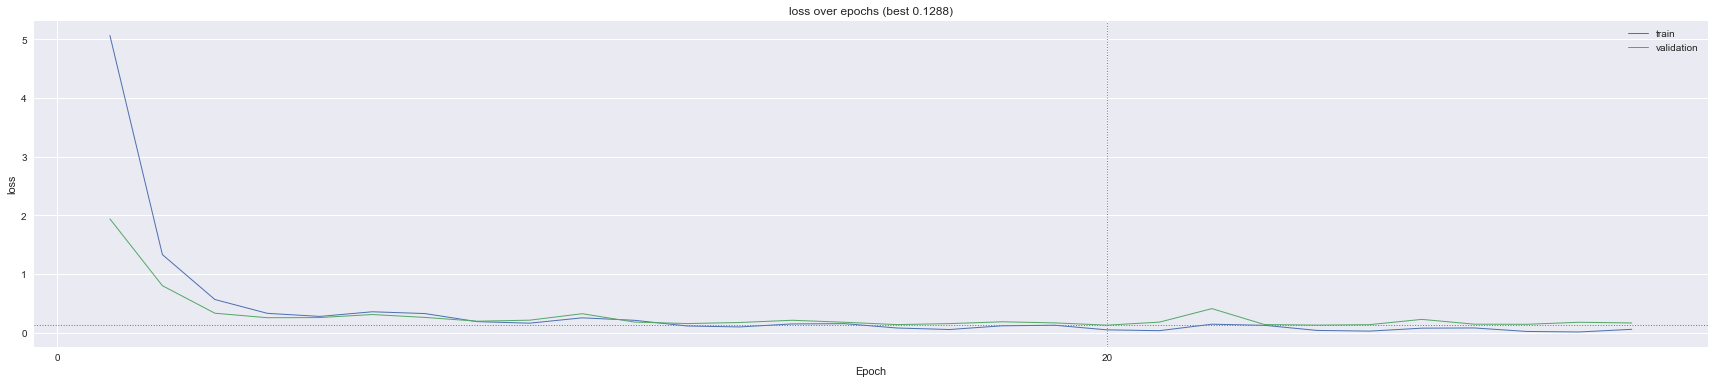

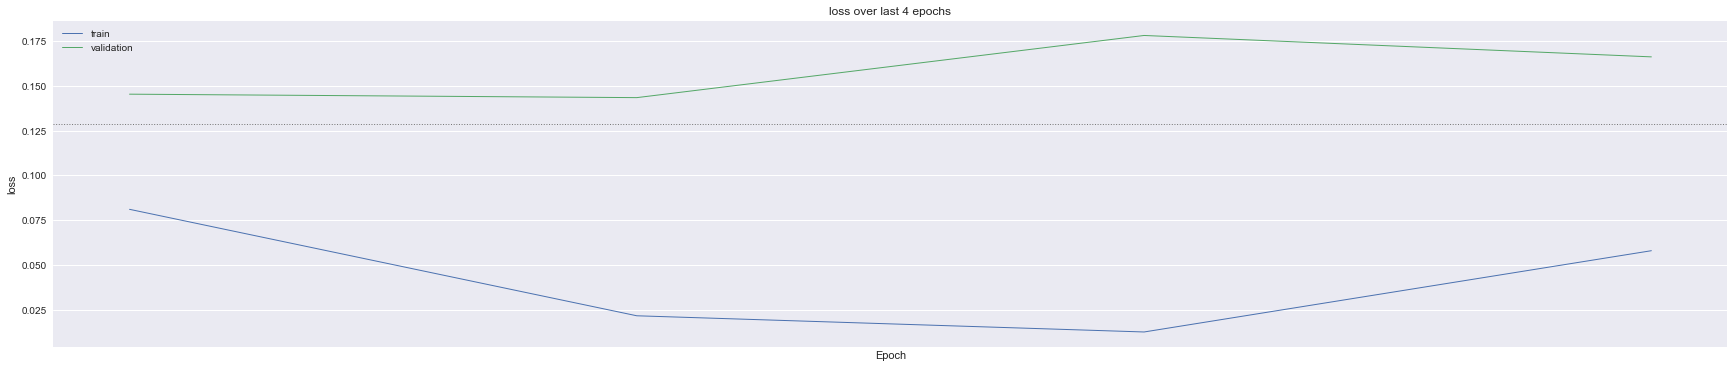

In [90]:
pretty_plot(history_google, 'loss', lambda x: np.argmin(x))

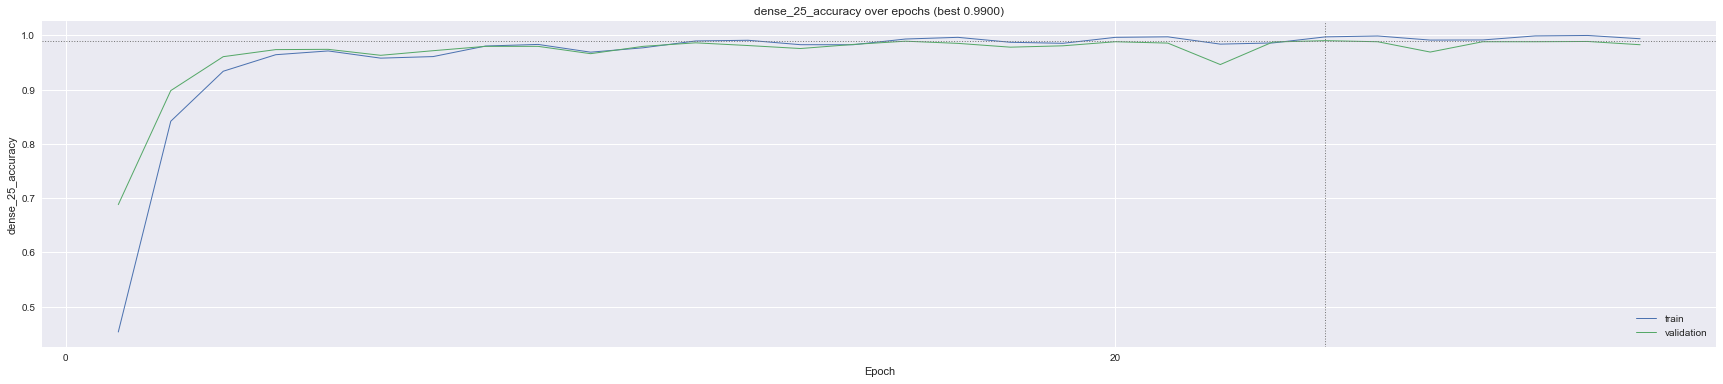

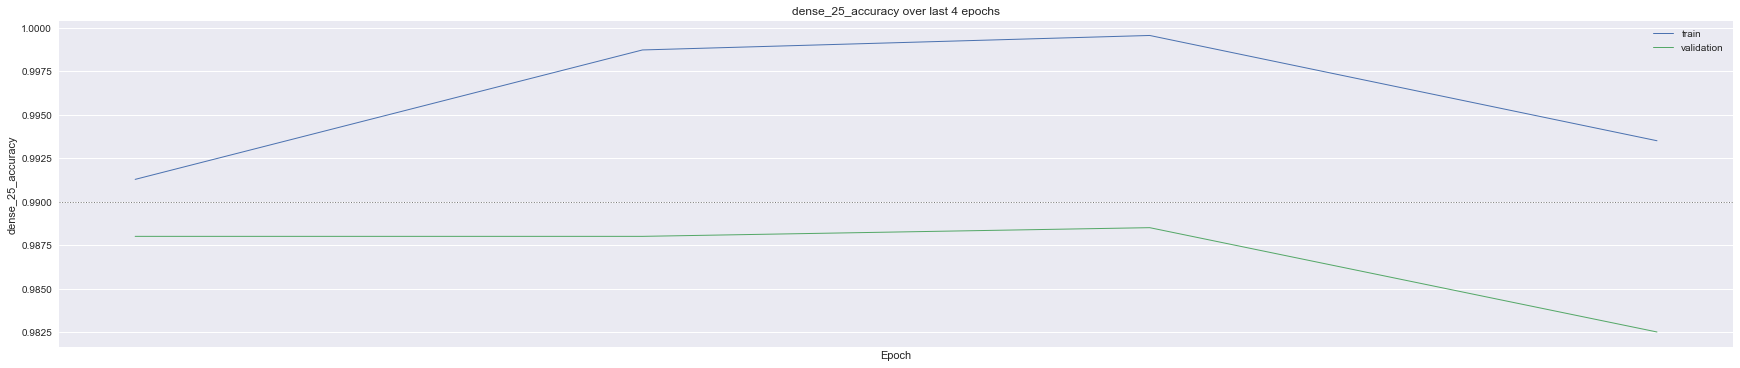

In [92]:
pretty_plot(history_google, 'dense_25_accuracy', lambda x: np.argmax(x))

In [93]:
m_google_model.load_weights('weights_google.hdf5')
X_mitbih_test = m_google_model.evaluate(X_mitbihl_test, y_mitbihl_test)

157/157 [==============================] - 10s 65ms/step - loss: 0.1353 - dense_25_loss: 0.0440 - dense_22_loss: 0.0468 - dense_24_loss: 0.0445 - dense_25_accuracy: 0.9890 - dense_22_accuracy: 0.9878 - dense_24_accuracy: 0.9880


In [94]:
y_pred1 = tf.argmax(m_google_model.predict(X_mitbihl_test), axis=-1)
# Compute confusion matrix
cnf_matrix1 = sklearn.metrics.confusion_matrix(y_mitbih_test, y_pred1)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=['N', 'L', 'R', 'A', 'V'],
                      title='Confusion matrix, without normalization')

ValueError: Can't convert non-rectangular Python sequence to Tensor.

### VGG model

In [35]:
def get_vgg_model(categories=2):

    inputs = keras.layers.Input([360,1])
    kernels = 32
    stride = 5
    X = keras.layers.Conv1D(kernels, stride)(inputs)
    
    out = keras.layers.Conv1D(kernels, stride, padding='same')(X)
    out = keras.layers.ReLU()(out)
    out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.ReLU()(out)
    out = keras.layers.MaxPool1D(5, 2)(out)

    out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.ReLU()(out)
    out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.ReLU()(out)
    out = keras.layers.MaxPool1D(5, 2)(out)

    out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.ReLU()(out)
    out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.ReLU()(out)
    out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.ReLU()(out)
    out = keras.layers.MaxPool1D(5, 2)(out)
    
    out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.ReLU()(out)
    out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.ReLU()(out)
    out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.ReLU()(out)
    out = keras.layers.MaxPool1D(5, 2)(out)
    
    out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.ReLU()(out)
    out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.ReLU()(out)
    out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.ReLU()(out)
    out = keras.layers.MaxPool1D(5, 2)(out)
    
    out = keras.layers.Flatten()(out)
    out = keras.layers.Dense(32, activation='relu')(out)
    out = keras.layers.Dense(32, activation='relu')(out)
    output = (keras.layers.Dense(1, activation='sigmoid')(out) if categories == 2 else keras.layers.Dense(5, activation='softmax')(out))

    model = keras.Model(inputs=inputs, outputs=output)

    return model


In [36]:
N = X_mitbih_train.shape[0]
batch_size = 128
iterations = N/batch_size
step_size= 2 * iterations

lr_schedule = CyclicalLearningRate(1e-5, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
m_vgg_model = get_vgg_model(5)

save_vgg_weights = ModelCheckpoint(filepath="weights_vgg.hdf5", verbose=0, save_best_only=True)

m_vgg_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_vgg = m_vgg_model.fit(X_mitbihl_train, y_mitbihl_train, validation_data=(X_mitbihl_val, y_mitbihl_val), 
                             shuffle=True, batch_size=128, epochs=30, callbacks=[save_vgg_weights])

Epoch 1/30

141/141 [==============================] - 32s 206ms/step - loss: 1.1638 - accuracy: 0.4761 - val_loss: 0.5643 - val_accuracy: 0.8240

Epoch 2/30

141/141 [==============================] - 35s 247ms/step - loss: 0.3976 - accuracy: 0.8698 - val_loss: 0.2899 - val_accuracy: 0.9060

Epoch 3/30

141/141 [==============================] - 37s 259ms/step - loss: 0.2136 - accuracy: 0.9294 - val_loss: 0.1636 - val_accuracy: 0.9455

Epoch 4/30

141/141 [==============================] - 33s 237ms/step - loss: 0.1241 - accuracy: 0.9572 - val_loss: 0.1258 - val_accuracy: 0.9610

Epoch 5/30

141/141 [==============================] - 33s 235ms/step - loss: 0.1043 - accuracy: 0.9651 - val_loss: 0.1488 - val_accuracy: 0.9495

Epoch 6/30

141/141 [==============================] - 32s 228ms/step - loss: 0.1435 - accuracy: 0.9509 - val_loss: 0.1707 - val_accuracy: 0.9445

Epoch 7/30

141/141 [==============================] - 27s 191ms/step - loss: 0.1244 - accuracy: 0.9586 - val_loss: 0.

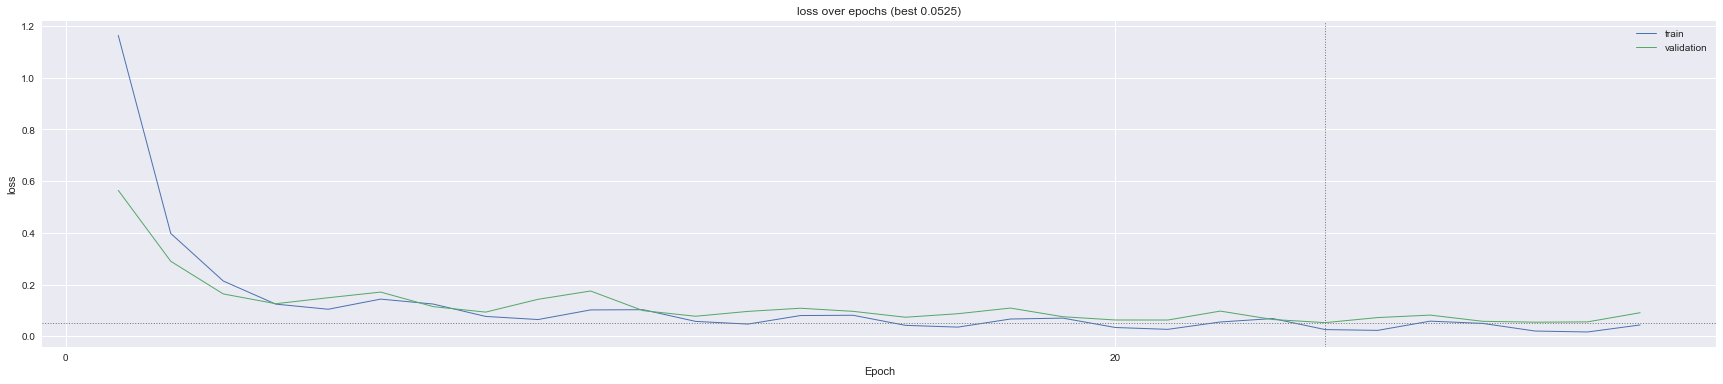

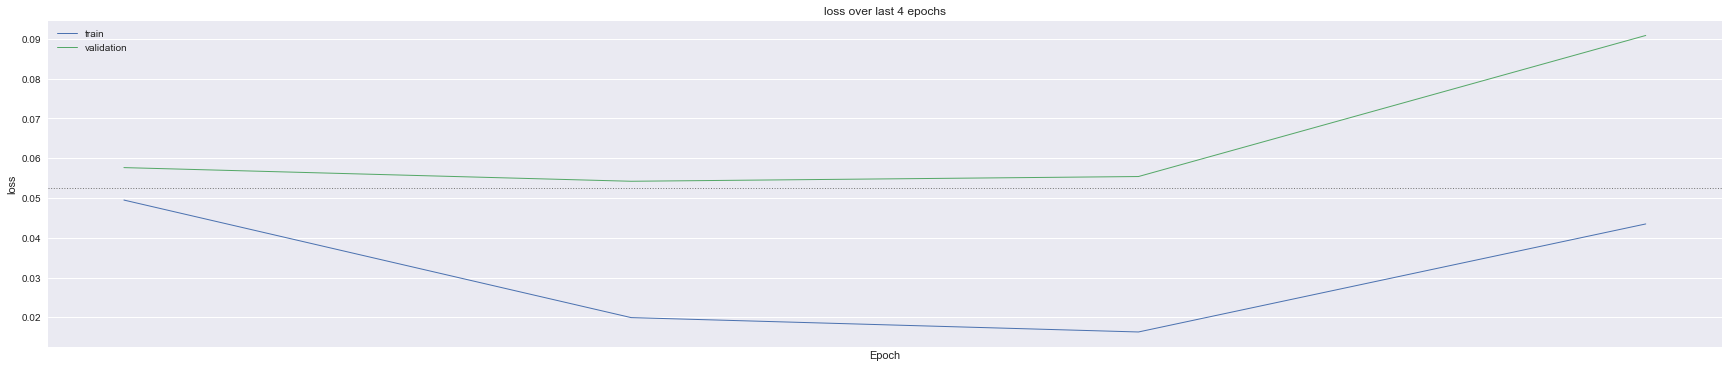

In [46]:
pretty_plot(history_vgg, 'loss', lambda x: np.argmin(x))

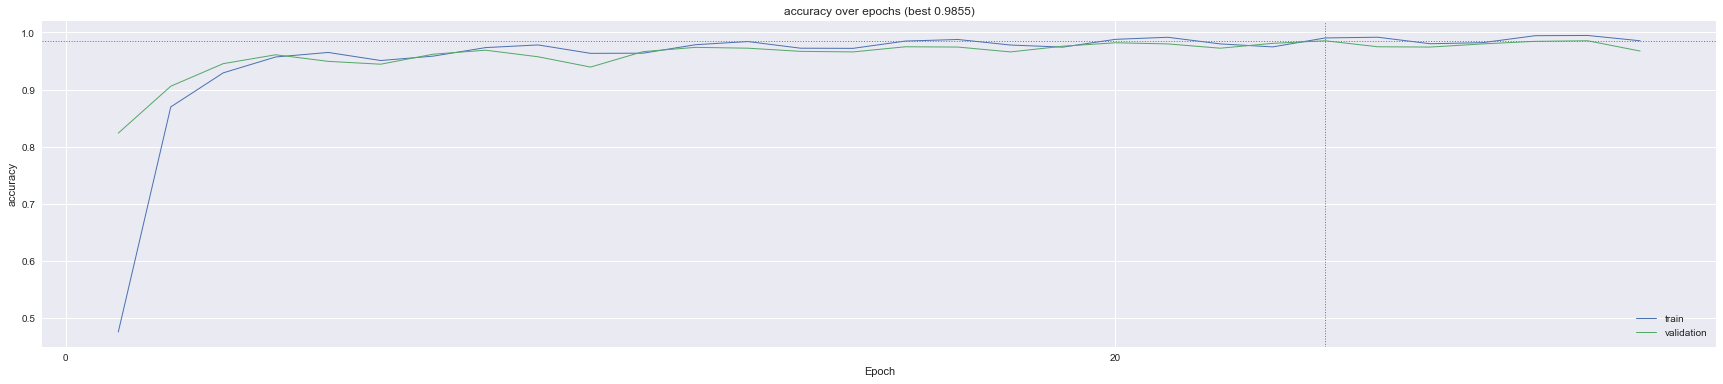

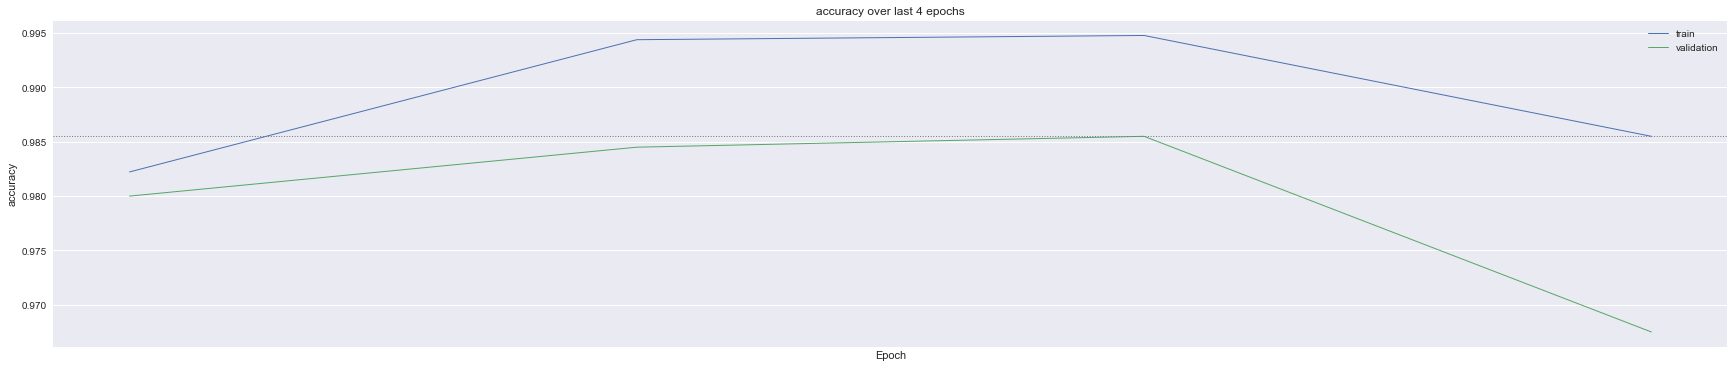

In [47]:
pretty_plot(history_vgg, 'accuracy', lambda x: np.argmax(x))

In [48]:
m_vgg_model.load_weights('weights_vgg.hdf5')
X_mitbih_test = m_vgg_model.evaluate(X_mitbihl_test, y_mitbihl_test)

157/157 [==============================] - 4s 22ms/step - loss: 0.0686 - accuracy: 0.9844


Confusion matrix, without normalization

[[958   2   0  36   5]

 [  1 993   0   1   5]

 [  2   1 999   2   1]

 [ 14   0   3 974   0]

 [  4   0   0   1 998]]


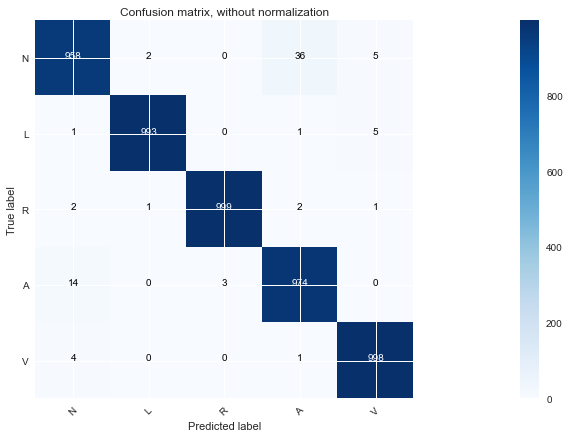

In [49]:
y_pred1 = tf.argmax(m_vgg_model.predict(X_mitbihl_test), axis=-1)
# Compute confusion matrix
cnf_matrix1 = sklearn.metrics.confusion_matrix(y_mitbih_test, y_pred1)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=['N', 'L', 'R', 'A', 'V'],
                      title='Confusion matrix, without normalization')

### ResNet Model

In [38]:
def get_resnet_model(categories=2):
    def residual_block(X, kernels, stride):
        out = keras.layers.Conv1D(kernels, stride, padding='same')(X)
        out = keras.layers.ReLU()(out)
        out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
        out = keras.layers.add([X, out])
        out = keras.layers.ReLU()(out)
        out = keras.layers.MaxPool1D(5, 2)(out)
        return out
    kernels = 32
    stride = 5

    inputs = keras.layers.Input([360,1])
    X = keras.layers.Conv1D(kernels, stride)(inputs)
    X = residual_block(X, kernels, stride)
    X = residual_block(X, kernels, stride)
    X = residual_block(X, kernels, stride)
    X = residual_block(X, kernels, stride)
    X = residual_block(X, kernels, stride)
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(32, activation='relu')(X)
    X = keras.layers.Dense(32, activation='relu')(X)
    output = (keras.layers.Dense(1, activation='sigmoid')(X) if categories == 2 else keras.layers.Dense(5, activation='softmax')(X))

    model = keras.Model(inputs=inputs, outputs=output)
    return model

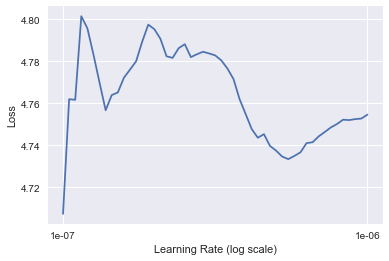

In [39]:
optimizer = Adam(learning_rate=0.001)
model = get_resnet_model(5) 
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-06, max_steps=50, smoothing=0.6)
_ = model.fit(X_mitbihl_train, y_mitbihl_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

In [40]:
N = X_mitbih_train.shape[0]
batch_size = 128
iterations = N/batch_size
step_size= 2 * iterations

lr_schedule = CyclicalLearningRate(1e-5, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
m_resnet_model = get_resnet_model(5)

save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

m_resnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = m_resnet_model.fit(X_mitbihl_train, y_mitbihl_train, validation_data=(X_mitbihl_val, y_mitbihl_val), 
                             shuffle=True, batch_size=128, epochs=30, callbacks=[save_best_weights])

Epoch 1/30

141/141 [==============================] - 28s 185ms/step - loss: 0.9570 - accuracy: 0.6271 - val_loss: 0.3516 - val_accuracy: 0.8890


C:\Users\csgad\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/30

141/141 [==============================] - 27s 190ms/step - loss: 0.3008 - accuracy: 0.9007 - val_loss: 0.2386 - val_accuracy: 0.9155

Epoch 3/30

141/141 [==============================] - 26s 186ms/step - loss: 0.1898 - accuracy: 0.9353 - val_loss: 0.1525 - val_accuracy: 0.9435

Epoch 4/30

141/141 [==============================] - 28s 197ms/step - loss: 0.1262 - accuracy: 0.9580 - val_loss: 0.1080 - val_accuracy: 0.9595

Epoch 5/30

141/141 [==============================] - 26s 187ms/step - loss: 0.1123 - accuracy: 0.9616 - val_loss: 0.1305 - val_accuracy: 0.9520

Epoch 6/30

141/141 [==============================] - 27s 189ms/step - loss: 0.1399 - accuracy: 0.9527 - val_loss: 0.1824 - val_accuracy: 0.9385

Epoch 7/30

141/141 [==============================] - 26s 184ms/step - loss: 0.1261 - accuracy: 0.9554 - val_loss: 0.0870 - val_accuracy: 0.9665

Epoch 8/30

141/141 [==============================] - 26s 184ms/step - loss: 0.0784 - accuracy: 0.9724 - val_loss: 0.

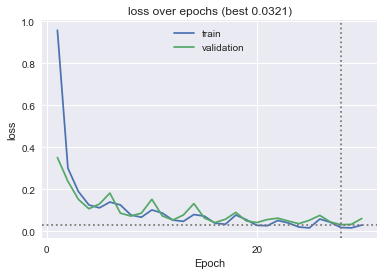

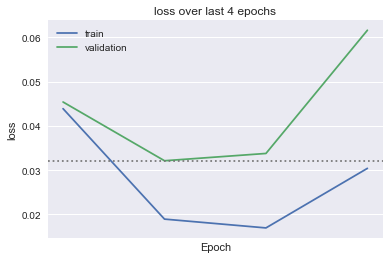

In [41]:
pretty_plot(history, 'loss', lambda x: np.argmin(x))

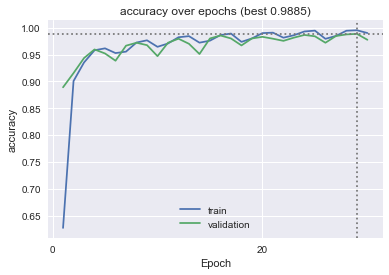

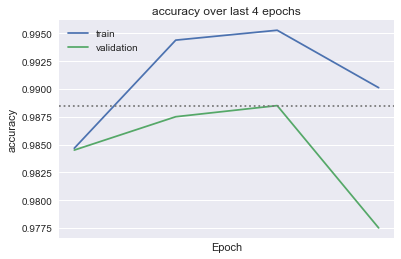

In [42]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

In [43]:
m_resnet_model.load_weights('weights.hdf5')
X_mitbih_test = m_resnet_model.evaluate(X_mitbihl_test, y_mitbihl_test)

157/157 [==============================] - 3s 21ms/step - loss: 0.0415 - accuracy: 0.9868


Confusion matrix, without normalization

[[ 981    6    1   24    5]

 [   2  972    0    2    1]

 [   3    0  970    1    0]

 [  12    0    3 1011    1]

 [   3    1    0    1 1000]]


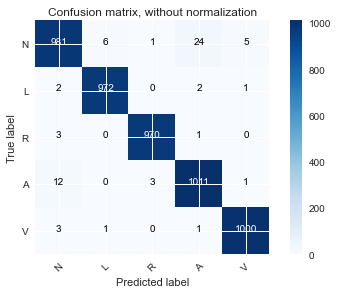

In [44]:
y_pred = tf.argmax(m_resnet_model.predict(X_mitbihl_test), axis=-1)
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_mitbih_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['N', 'L', 'R', 'A', 'V'],
                      title='Confusion matrix, without normalization')

In [45]:
from sklearn.metrics import classification_report

In [46]:
#ResNet Sampled classification report
print(classification_report(y_mitbih_test,y_pred))

              precision    recall  f1-score   support



         0.0       0.98      0.96      0.97      1017

         1.0       0.99      0.99      0.99       977

         2.0       1.00      1.00      1.00       974

         3.0       0.97      0.98      0.98      1027

         4.0       0.99      1.00      0.99      1005



    accuracy                           0.99      5000

   macro avg       0.99      0.99      0.99      5000

weighted avg       0.99      0.99      0.99      5000




In [44]:
m_resnet_model.summary()

Model: "model_3"

__________________________________________________________________________________________________

Layer (type)                    Output Shape         Param #     Connected to                     


input_4 (InputLayer)            [(None, 360, 1)]     0                                            

__________________________________________________________________________________________________

conv1d_36 (Conv1D)              (None, 356, 32)      192         input_4[0][0]                    

__________________________________________________________________________________________________

conv1d_37 (Conv1D)              (None, 356, 32)      5152        conv1d_36[0][0]                  

__________________________________________________________________________________________________

re_lu_33 (ReLU)                 (None, 356, 32)      0           conv1d_37[0][0]                  

_________________________________________________________________________________

In [45]:
m_vgg_model.summary()

Model: "model_1"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


input_2 (InputLayer)         [(None, 360, 1)]          0         

_________________________________________________________________

conv1d_11 (Conv1D)           (None, 356, 32)           192       

_________________________________________________________________

conv1d_12 (Conv1D)           (None, 356, 32)           5152      

_________________________________________________________________

re_lu_10 (ReLU)              (None, 356, 32)           0         

_________________________________________________________________

conv1d_13 (Conv1D)           (None, 356, 32)           5152      

_________________________________________________________________

re_lu_11 (ReLU)              (None, 356, 32)           0         

_________________________________________________________________

max_pooling1d_5 (MaxPooling1 (None, 176, 32

In [70]:
def get_transfer_model(model):
    model.trainable = False
    model_input = model.inputs
    model_output = model.layers[-4].output

    X = keras.layers.Dense(32, activation='relu')(model_output)
    X = keras.layers.Dense(32, activation='relu')(X)
    out = keras.layers.Dense(1, activation='sigmoid')(X)

    transfer_model = keras.Model(inputs=model_input, outputs=out)
    return transfer_model

get_transfer_model(m_resnet_model).summary()

Model: "model_4"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_2 (InputLayer)           [(None, 360, 1)]     0           []                               

                                                                                                  

 conv1d_11 (Conv1D)             (None, 356, 32)      192         ['input_2[0][0]']                

                                                                                                  

 conv1d_12 (Conv1D)             (None, 356, 32)      5152        ['conv1d_11[0][0]']              

                                                                                                  

 re_lu_10 (ReLU)                (None, 356, 32)      0           ['conv1d_12[0][0]']              

                                                                                 

In [129]:
def get_transfer_model(model):
    model.trainable = False
    model_input = model.inputs
    model_output = model.layers[-4].output

    X = keras.layers.Dense(32, activation='relu')(model_output)
    X = keras.layers.Dense(32, activation='relu')(X)
    out = keras.layers.Dense(1, activation='sigmoid')(X)

    transfer_model = keras.Model(inputs=model_input, outputs=out)
    return transfer_model

get_transfer_model(m_vgg_model).summary()

Model: "model_12"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


input_24 (InputLayer)        [(None, 360, 1)]          0         

_________________________________________________________________

conv1d_293 (Conv1D)          (None, 356, 32)           192       

_________________________________________________________________

conv1d_294 (Conv1D)          (None, 356, 32)           5152      

_________________________________________________________________

re_lu_268 (ReLU)             (None, 356, 32)           0         

_________________________________________________________________

conv1d_295 (Conv1D)          (None, 356, 32)           5152      

_________________________________________________________________

re_lu_269 (ReLU)             (None, 356, 32)           0         

_________________________________________________________________

max_pooling1d_89 (MaxPooling (None, 176, 3

In [71]:
# optimizer = keras.optimizers.Adam(lr=0.001)
# transfer_model = get_transfer_model(m_resnet_model)

# save_best_weights = ModelCheckpoint(filepath="tweights.hdf5", verbose=0, save_best_only=True)

# transfer_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# history = transfer_model.fit(X_mitbih_train, y_mitbih_train, validation_data=(X_mitbih_val,y_mitbih_val), 
#                              shuffle=True, batch_size=128, epochs=100, callbacks=[save_best_weights])
     

In [72]:
# pretty_plot(history, 'loss', lambda x: np.argmin(x))

In [73]:
# pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

In [45]:
model = VGG19(In_channel=1,classes=5)
input = torch.randn(size=(1,1,224))
output = model(input)
print(f"输出大小{output.shape}")
print(model)
summary(model=model, input_size=(1, 224), device='cpu')

输出大小torch.Size([1, 5])

VGG19(

  (feature): Sequential(

    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))

    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (2): ReLU()

    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))

    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (5): ReLU()

    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

    (7): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))

    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (9): ReLU()

    (10): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))

    (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (12): ReLU()

    (13): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

    (14): Conv1d(128, 256, kernel_size=(3,), stride=(1,)